# GeoGrapher tutorial - creating a ML dataset

This tutorial shows how to use geographer to create a remote sensing dataset from a dataset of vector data and large raster tiles. If you are reading the html version in the documentation and would prefer the actual ipynb file you can find it [here](https://github.com/dida-do/GeoGrapher/tree/main/notebooks/tutorial_nb_cut_label_cluster.ipynb). We will use the example dataset of stadiums created in the tutorial_nb_basics.ipynb notebook. More advanced examples of the very general cutting capabilities that GeoGrapher provides can be found in the documentation and in a soon forthcoming notebook.

Contents:

1. Basic cutting
2. Making segmentation labels
3. Updating the new dataset
4. Creating a train/val split

## 1. Basic cutting

First, we import geographer, as well as some other imports we will need.

In [ ]:
# !pip install geographer matplotlib

In [20]:
import geographer as gg
import shutil
from pathlib import Path
import rioxarray
from matplotlib import pyplot as plt

First, we load the connector for the dataset:

In [21]:
from geographer import Connector

SOURCE_DATA_DIR = Path("gg_example_dataset")

connector = Connector.from_data_dir(SOURCE_DATA_DIR)

We now show how to do basic dataset cutting on our example dataset. There are three reasons we want to cut the datset:

* The Sentinel-2 raster tiles in this dataset are very large. Each tile is 10980 by 10980 pixels or (given that the resolution is 10m) around 100km by 100km. Sentinel-2 tiles also can have a lot of channels. The resulting files are too large to load into a GPU to do deep learning. To be able to comfortably work with them, we need to create a dataset of smaller rasters.
* We do not know if the large tiles contain other stadiums and we want to avoid false negatives in the labels (i.e. stadiums that have not been labeled as such and are counted as belonging to the background). False negatives in the labels would confuse ML models and make it harder for them to learn.
* Since almost all of the pixels in a tile belong to the background class the foreground/backgroun class imbalance will be extreme, which will make it hard for ML models to learn. Even if we would like our ML model to eventually be able to identify stadiums on real life data with a high class imbalance in production, we want to train on a dataset with a more manageable class imbalance.

GeoGrapher's provides two very general templates for cutting that provide a very large amount of flexibility for how datasets can be cut: iterating over vector features and iterating over rasters. To simplify the complexity of using these for basic use cases, GeoGrapher provides two functions that should provide sensible default behavior for a wide variety of applications. One returns a cutter that creates cutouts around vector features, and one that cuts every raster in the source dataset to a grid of rasters. In this example we want to use the former. We have two rasters per vector feature in our source dataset, and let us say that we want to create two cutouts (from separate rasters) for each vector feature.

Let us start with the imports:

In [22]:
from geographer.cutters import get_cutter_rasters_around_every_vector

We use this function to get a dataset cutter.

In [23]:
IMG_SIZE = 512
TARGET_DATA_DIR = Path(f"gg_example_dataset_cutouts{IMG_SIZE}")

cutter = get_cutter_rasters_around_every_vector(
    source_data_dir=SOURCE_DATA_DIR,
    target_data_dir=TARGET_DATA_DIR,
    name="Our first cutter",  # for saving, see below
    new_raster_size=IMG_SIZE,  # in pixels
    target_raster_count=2,  # we want to create two different raster cutouts per vector feature
    bands={"rasters": [1, 2, 3]},  # we only want the RGB (or BGR for Sentinel-2) bands
    mode="random",  # defines the way cutouts are chosen. this is the default value, but you can choose other modes.
)

Now we can cut the dataset (i.e. create a new dataset in `TARGET_DATA_DIR` composed of cutouts from the dataset in `SOURCE_DATA_DIR`) using the cutter's `cut` method. The return value is the connector of the newly created target dataset.

In [24]:
target_connector = cutter.cut()

Cutting dataset: 100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Let's take a look at the rasters in the new dataset ...

In [25]:
target_connector.rasters

,geometry,raster_processed?,timestamp,orig_crs_epsg_code
raster_name,,,,
S2B_MSIL2A_20220804T101559_N0400_R065_T32UPU_20220804T130854_Munich Olympiastadion.tif,"POLYGON ((11.58895 48.14840, 11.58895 48.19594...",True,2022-08-04-10:15:59,32632
S2A_MSIL2A_20220627T100611_N0400_R022_T32UPU_20220627T162810_Munich Olympiastadion.tif,"POLYGON ((11.56448 48.17054, 11.56448 48.21807...",True,2022-06-27-10:06:11,32632
S2A_MSIL2A_20220627T100611_N0400_R022_T32UPU_20220627T162810_Munich Staedtisches Stadion Dantestr.tif,"POLYGON ((11.56403 48.12907, 11.56403 48.17660...",True,2022-06-27-10:06:11,32632
S2A_MSIL2A_20220413T092031_N0400_R093_T34TFN_20220413T123632_Vasil Levski National Stadium.tif,"POLYGON ((23.37083 42.68422, 23.37083 42.73156...",True,2022-04-13-09:20:31,32634
S2A_MSIL2A_20220722T092041_N0400_R093_T34TFN_20220722T134859_Vasil Levski National Stadium.tif,"POLYGON ((23.35795 42.66350, 23.35795 42.71084...",True,2022-07-22-09:20:41,32634
S2A_MSIL2A_20220413T092031_N0400_R093_T34TFN_20220413T123632_Bulgarian Army Stadium.tif,"POLYGON ((23.40157 42.67061, 23.40157 42.71797...",True,2022-04-13-09:20:31,32634
S2A_MSIL2A_20220412T012701_N0400_R074_T54SUE_20220412T042315_Jingu Baseball Stadium.tif,"POLYGON ((139.76736 35.65410, 139.76736 35.700...",True,2022-04-12-01:27:01,32654
S2A_MSIL2A_20220701T012711_N0400_R074_T54SUE_20220701T043318_Jingu Baseball Stadium.tif,"POLYGON ((139.75258 35.66693, 139.75258 35.713...",True,2022-07-01-01:27:11,32654


... and at the `vectors`:

In [26]:
target_connector.vectors

,geometry,raster_count,location,download_exception,type
vector_name,,,,,
Munich Olympiastadion,"POLYGON Z ((11.54677 48.17472 0.00000, 11.5446...",3,"Munich, Germany",NoImgsForVectorFeatureFoundError('No images fo...,football
Munich Track and Field Stadium1,"POLYGON Z ((11.54382 48.17279 0.00000, 11.5438...",3,"Munich, Germany",NoImgsForVectorFeatureFoundError('No images fo...,football
Munich Olympia Track and Field2,"POLYGON Z ((11.54686 48.17892 0.00000, 11.5468...",2,"Munich, Germany",NoImgsForVectorFeatureFoundError('No images fo...,football
Munich Staedtisches Stadion Dantestr,"POLYGON Z ((11.52913 48.16874 0.00000, 11.5291...",2,"Munich, Germany",NoImgsForVectorFeatureFoundError('No images fo...,football
Vasil Levski National Stadium,"POLYGON Z ((23.33410 42.68813 0.00000, 23.3340...",2,"Sofia, Bulgaria",NoImgsForVectorFeatureFoundError('No images fo...,football
Bulgarian Army Stadium,"POLYGON Z ((23.34065 42.68492 0.00000, 23.3406...",2,"Sofia, Bulgaria",NoImgsForVectorFeatureFoundError('No images fo...,football
Arena Sofia,"POLYGON Z ((23.34018 42.68318 0.00000, 23.3401...",2,"Sofia, Bulgaria",NoImgsForVectorFeatureFoundError('No images fo...,football
Jingu Baseball Stadium,"POLYGON Z ((139.71597 35.67490 0.00000, 139.71...",2,"Tokyo, Japan",NoImgsForVectorFeatureFoundError('No images fo...,baseball
Japan National Stadium,"POLYGON Z ((139.71482 35.67644 0.00000, 139.71...",2,"Tokyo, Japan",NoImgsForVectorFeatureFoundError('No images fo...,football


Note: We see in the `raster_count` column that most stadiums are contained in exactly two rasters, but (depending on the rasters in your dataset) some might be contained in three rasters. Choosing how to create cutouts to reach the targeted `raster_count` is a combinatorially hard problem and this cutter uses a greedy heuristic to select images to approximatively achieve the targeted `raster_count` which in practice works well (one can also experiment with different random seeds, which can help). What can happen is that at some stage in the iteration the `target_raster_count` for some vector features V in a cluster C has been reached, but when creating cutouts for the remaining rasters C-V in the cluster the cutouts contain vector features from V. The `raster_count` may also be less than `target_raster_count` if there are not enough rasters in the source source dataset to reach the targeted `raster_count` (e.g. in this example if we had set `target_raster_count` to 10).

If instead of creating cutouts around the vector stadiums we want to just cut each raster in the source directory to a grid of rasters, we can use the `get_cutter_every_raster_to_grid` function from `geographer.cutters`.

The stadiums have now been added to the connector's `vectors` GeoDataFrame:

## 2. Making segmentation labels

To make segmentation labels, we use `LabelMakers`. The particular `LabelMaker` we want to use is `SegLabelMakerCategorical`. This is the reason we set the `task_vector_classes` argument in the [tutorial notebook on GeoGrapher basics](https://github.com/dida-do/GeoGrapher/tree/main/notebooks/stadiums.geojson) in which we created the dataset. The label maker uses the `connector.task_vector_classes` attribute for a safety check.

In [27]:
from geographer.label_makers import SegLabelMakerCategorical

label_maker = SegLabelMakerCategorical()
label_maker.make_labels(connector=target_connector)

Making labels: 100%|██████████| 8/8 [00:00<00:00, 34.09it/s]


If we had made labels for our source dataset in `SOURCE_DATA_DIR` then because the dataset cutters will also create cutouts for the labels we would not have had to create labels for the new dataset in `TARGET_DATA_DIR` again.

Let's take a look at a raster and it's segmentation mask:

(-0.5, 511.5, 511.5, -0.5)

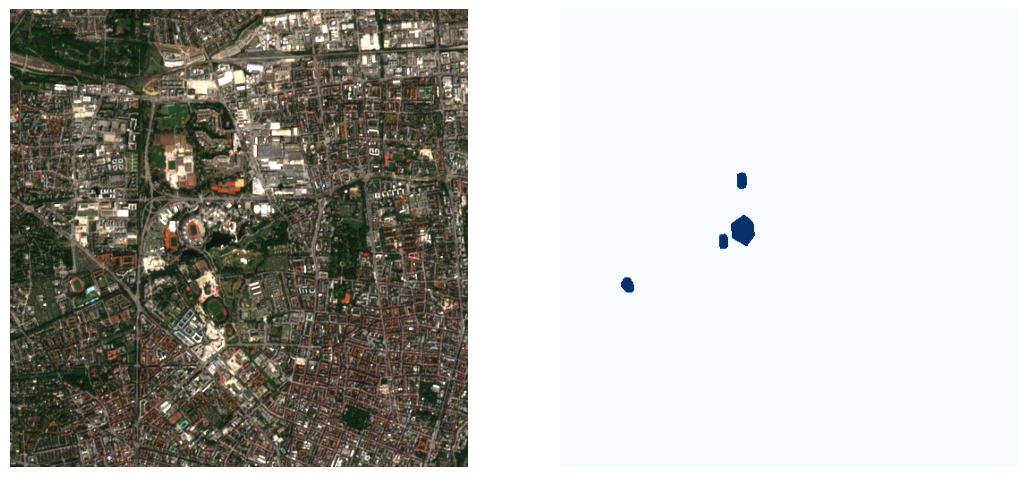

In [28]:
raster_paths = target_connector.rasters_containing_vector(
    "Munich Olympiastadion", mode="paths"
)
raster_path = raster_paths[0]
label_path = target_connector.labels_dir / raster_path.name

raster = (
    rioxarray.open_rasterio(raster_path).sel(band=[1, 2, 3]).values.transpose(1, 2, 0)
    / 65535
)
label = rioxarray.open_rasterio(label_path).values.transpose(1, 2, 0) / 255

fig, ax = plt.subplots(1, 2, figsize=(13, 13))

ax[0].imshow(raster)
ax[0].axis("off")

ax[1].imshow(label, cmap="Blues")
ax[1].axis("off")

## 3. Updating the new dataset

If the source dataset grows to contain more vector features or rasters we can update the dataset of cutouts. Let's simulate this situation by copying the source dataset, deleting some vector features and rasters, cutting the dataset as above, and adding them back again to the source dataset. Then we will see how easy it is to update the dataset of cutouts.

Here we copy the source dataset to `TRUNCATED_SOURCE_DATA_DIR`:

In [29]:
TRUNCATED_SOURCE_DATA_DIR = SOURCE_DATA_DIR.parent / (
    SOURCE_DATA_DIR.name + "_truncated"
)

shutil.copytree(SOURCE_DATA_DIR, TRUNCATED_SOURCE_DATA_DIR)

PosixPath('gg_example_dataset_truncated')

Let's delete some vector features and rasters from the truncated source dataset. We use the `drop_vectors` and `drop_rasters` methods. The `label_maker` arguments are optional. If given they will in the case of `drop_vectors` update labels for rasters from which vector features have been removed and in the case of `drop_rasters` delete the segmentation labels corresponding to the rasters.

In [30]:
truncated_source_connector = Connector.from_data_dir(TRUNCATED_SOURCE_DATA_DIR)
vectors_to_drop = ["Munich Olympiastadion", "Munich Track and Field Stadium1"]
truncated_source_connector.drop_vectors(vectors_to_drop, label_maker=label_maker)
candidate_rasters_to_drop = truncated_source_connector.rasters_containing_vector(
    "Munich Olympia Track and Field2"
)
raster_to_drop = candidate_rasters_to_drop[0]
truncated_source_connector.drop_rasters(
    raster_to_drop,
    remove_rasters_from_disk=True,  # default value
    label_maker=label_maker,
)

Deleting labels: 100%|██████████| 1/1 [00:00<00:00, 7825.19it/s]


Make sure to save the changes:

In [31]:
truncated_source_connector.save()

Let's make sure `vectors` and `rasters` look as they should. Notice how the `raster_count` column in `vectors` is consistent with the removals we've made.

In [32]:
truncated_source_connector.vectors

,raster_count,location,download_exception,type,geometry
vector_name,,,,,
Munich Olympia Track and Field2,1,"Munich, Germany",NoImgsForVectorFeatureFoundError('No images fo...,football,"POLYGON Z ((11.54686 48.17892 0.00000, 11.5468..."
Munich Staedtisches Stadion Dantestr,1,"Munich, Germany",NoImgsForVectorFeatureFoundError('No images fo...,football,"POLYGON Z ((11.52913 48.16874 0.00000, 11.5291..."
Vasil Levski National Stadium,2,"Sofia, Bulgaria",NoImgsForVectorFeatureFoundError('No images fo...,football,"POLYGON Z ((23.33410 42.68813 0.00000, 23.3340..."
Bulgarian Army Stadium,2,"Sofia, Bulgaria",NoImgsForVectorFeatureFoundError('No images fo...,football,"POLYGON Z ((23.34065 42.68492 0.00000, 23.3406..."
Arena Sofia,2,"Sofia, Bulgaria",NoImgsForVectorFeatureFoundError('No images fo...,football,"POLYGON Z ((23.34018 42.68318 0.00000, 23.3401..."
Jingu Baseball Stadium,2,"Tokyo, Japan",NoImgsForVectorFeatureFoundError('No images fo...,baseball,"POLYGON Z ((139.71597 35.67490 0.00000, 139.71..."
Japan National Stadium,2,"Tokyo, Japan",NoImgsForVectorFeatureFoundError('No images fo...,football,"POLYGON Z ((139.71482 35.67644 0.00000, 139.71..."


In [33]:
truncated_source_connector.rasters

,raster_processed?,timestamp,orig_crs_epsg_code,geometry
raster_name,,,,
S2A_MSIL2A_20220722T092041_N0400_R093_T34TFN_20220722T134859.tif,True,2022-07-22-09:20:41,32634,"POLYGON ((23.54663 42.33578, 23.58754 43.32358..."
S2A_MSIL2A_20220413T092031_N0400_R093_T34TFN_20220413T123632.tif,True,2022-04-13-09:20:31,32634,"POLYGON ((23.54663 42.33578, 23.58754 43.32358..."
S2B_MSIL2A_20220804T101559_N0400_R065_T32UPU_20220804T130854.tif,True,2022-08-04-10:15:59,32632,"POLYGON ((11.79809 47.73104, 11.85244 48.71769..."
S2A_MSIL2A_20220412T012701_N0400_R074_T54SUE_20220412T042315.tif,True,2022-04-12-01:27:01,32654,"POLYGON ((140.00972 35.15084, 139.99743 36.140..."
S2A_MSIL2A_20220701T012711_N0400_R074_T54SUE_20220701T043318.tif,True,2022-07-01-01:27:11,32654,"POLYGON ((140.00972 35.15084, 139.99743 36.140..."


Now, we can cut the truncated dataset and create labels for the cutouts as before:

In [34]:
# cutting

IMG_SIZE = 512
TARGET_DATA_DIR2 = Path(f"gg_example_dataset_truncated_cutouts{IMG_SIZE}")
TRUNCATED_CUTTER_NAME = "truncated_cutter"

cutter = get_cutter_rasters_around_every_vector(
    source_data_dir=SOURCE_DATA_DIR,
    target_data_dir=TARGET_DATA_DIR2,
    name=TRUNCATED_CUTTER_NAME,  # for saving, see below
    new_raster_size=IMG_SIZE,  # in pixels
    target_raster_count=2,  # we want to create two different raster cutouts per vector feature
    bands={"rasters": [1, 2, 3]},  # we only want the RGB (or BGR for Sentinel-2) bands
    mode="random",  # defines the way cutouts are chosen. this is the default value, but you can choose other modes.
)
truncated_target_connector = cutter.cut()

Cutting dataset: 100%|██████████| 9/9 [00:02<00:00,  3.21it/s]


In [35]:
# making labels

label_maker.make_labels(connector=truncated_target_connector)

Making labels: 100%|██████████| 8/8 [00:00<00:00, 36.00it/s]


Now, let's add the dropped data back:

In [36]:
source_connector = Connector.from_data_dir(SOURCE_DATA_DIR)

# copy over deleted raster
shutil.copy(
    source_connector.rasters_dir / raster_to_drop,
    truncated_source_connector.rasters_dir / raster_to_drop,
)

# add entries to rasters and vectors GeoDataFrames
truncated_source_connector.add_to_rasters(
    source_connector.rasters.loc[[raster_to_drop]]
)
truncated_source_connector.add_to_vectors(source_connector.vectors.loc[vectors_to_drop])

# save
truncated_source_connector.save()

Now, update the truncated target dataset. The cutter returned by `get_cutter_rasters_around_every_vector` is a `DSCutterIterOverVectors`. To load the saved cutter (we don't actually have to do that here, since the cutter variable is still bound, but in a normal workflow we would), we run:

In [37]:
from geographer.cutters import DSCutterIterOverVectors

cutter_json_path = TARGET_DATA_DIR2 / "connector" / f"{TRUNCATED_CUTTER_NAME}.json"
cutter = DSCutterIterOverVectors.from_json_file(cutter_json_path)

In [38]:
cutter.update()

Cutting dataset: : 0it [00:00, ?it/s]
/home/rustam/dida/GeoGrapher/geographer/utils/utils.py:177: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  concatenated_gdf = GeoDataFrame(pd.concat(objs, **kwargs), crs=objs[0].crs)


Now, we can check that the truncated target dataset has been updated. Note that we have to reload the `truncated_source_connector`.

In [39]:
truncated_target_connector = Connector.from_data_dir(TARGET_DATA_DIR2)
truncated_target_connector.vectors

,raster_count,location,download_exception,type,geometry
vector_name,,,,,
Munich Olympiastadion,3,"Munich, Germany",NoImgsForVectorFeatureFoundError('No images fo...,football,"POLYGON Z ((11.54677 48.17472 0.00000, 11.5446..."
Munich Track and Field Stadium1,3,"Munich, Germany",NoImgsForVectorFeatureFoundError('No images fo...,football,"POLYGON Z ((11.54382 48.17279 0.00000, 11.5438..."
Munich Olympia Track and Field2,2,"Munich, Germany",NoImgsForVectorFeatureFoundError('No images fo...,football,"POLYGON Z ((11.54686 48.17892 0.00000, 11.5468..."
Munich Staedtisches Stadion Dantestr,2,"Munich, Germany",NoImgsForVectorFeatureFoundError('No images fo...,football,"POLYGON Z ((11.52913 48.16874 0.00000, 11.5291..."
Vasil Levski National Stadium,2,"Sofia, Bulgaria",NoImgsForVectorFeatureFoundError('No images fo...,football,"POLYGON Z ((23.33410 42.68813 0.00000, 23.3340..."
Bulgarian Army Stadium,2,"Sofia, Bulgaria",NoImgsForVectorFeatureFoundError('No images fo...,football,"POLYGON Z ((23.34065 42.68492 0.00000, 23.3406..."
Arena Sofia,2,"Sofia, Bulgaria",NoImgsForVectorFeatureFoundError('No images fo...,football,"POLYGON Z ((23.34018 42.68318 0.00000, 23.3401..."
Jingu Baseball Stadium,2,"Tokyo, Japan",NoImgsForVectorFeatureFoundError('No images fo...,baseball,"POLYGON Z ((139.71597 35.67490 0.00000, 139.71..."
Japan National Stadium,2,"Tokyo, Japan",NoImgsForVectorFeatureFoundError('No images fo...,football,"POLYGON Z ((139.71482 35.67644 0.00000, 139.71..."


In [40]:
truncated_target_connector.rasters

,raster_processed?,timestamp,orig_crs_epsg_code,geometry
raster_name,,,,
S2B_MSIL2A_20220804T101559_N0400_R065_T32UPU_20220804T130854_Munich Olympiastadion.tif,1,2022-08-04-10:15:59,32632,"POLYGON ((11.58895 48.14840, 11.58895 48.19594..."
S2A_MSIL2A_20220627T100611_N0400_R022_T32UPU_20220627T162810_Munich Olympiastadion.tif,1,2022-06-27-10:06:11,32632,"POLYGON ((11.56448 48.17054, 11.56448 48.21807..."
S2A_MSIL2A_20220627T100611_N0400_R022_T32UPU_20220627T162810_Munich Staedtisches Stadion Dantestr.tif,1,2022-06-27-10:06:11,32632,"POLYGON ((11.56403 48.12907, 11.56403 48.17660..."
S2A_MSIL2A_20220413T092031_N0400_R093_T34TFN_20220413T123632_Vasil Levski National Stadium.tif,1,2022-04-13-09:20:31,32634,"POLYGON ((23.37083 42.68422, 23.37083 42.73156..."
S2A_MSIL2A_20220722T092041_N0400_R093_T34TFN_20220722T134859_Vasil Levski National Stadium.tif,1,2022-07-22-09:20:41,32634,"POLYGON ((23.35795 42.66350, 23.35795 42.71084..."
S2A_MSIL2A_20220413T092031_N0400_R093_T34TFN_20220413T123632_Bulgarian Army Stadium.tif,1,2022-04-13-09:20:31,32634,"POLYGON ((23.40157 42.67061, 23.40157 42.71797..."
S2A_MSIL2A_20220412T012701_N0400_R074_T54SUE_20220412T042315_Jingu Baseball Stadium.tif,1,2022-04-12-01:27:01,32654,"POLYGON ((139.76736 35.65410, 139.76736 35.700..."
S2A_MSIL2A_20220701T012711_N0400_R074_T54SUE_20220701T043318_Jingu Baseball Stadium.tif,1,2022-07-01-01:27:11,32654,"POLYGON ((139.75258 35.66693, 139.75258 35.713..."


If we want to, we can now check that the truncated target dataset has been updated correctly.

## 4. Creating a train/val split

To train a ML model it is essential to have a clean train/val split.
If you just naively split your rasters into a train and a validation set
there might be data leakage. Some vector features might intersect
several rasters. Also, rasters can overlap and there might be vector
features in the overlaps. GeoGrapher provides a function `get_raster_clusters`
that returns the minimal clusters of rasters such that if all rasters in each
cluster are assigned to the same dataset (training or validation) the resulting
split has no data leakage.

In [41]:
from __future__ import annotations

from geographer.utils.cluster_rasters import get_raster_clusters

clusters: list[set[str]] = get_raster_clusters(
    connector=connector,
    clusters_defined_by="rasters_that_share_vectors",
    preclustering_method="y then x-axis",
)
clusters

[{'S2A_MSIL2A_20220627T100611_N0400_R022_T32UPU_20220627T162810.tif',
  'S2B_MSIL2A_20220804T101559_N0400_R065_T32UPU_20220804T130854.tif'},
 {'S2A_MSIL2A_20220413T092031_N0400_R093_T34TFN_20220413T123632.tif',
  'S2A_MSIL2A_20220722T092041_N0400_R093_T34TFN_20220722T134859.tif'},
 {'S2A_MSIL2A_20220412T012701_N0400_R074_T54SUE_20220412T042315.tif',
  'S2A_MSIL2A_20220701T012711_N0400_R074_T54SUE_20220701T043318.tif'}]

As one might expect the clusters correspond to the different locations in our dataset: Munich, Tokyo, Sofia.